# Plot figures for brain left and right classification results

In [ ]:
import os
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat

from second_order_clf import fetch_weights
import sys
sys.path.insert(0, '..')

In [ ]:
def load_result(dataset, root_dir, lambdas, seed_start):
    """load brain left/right classification results for a dataset

    Args:
        dataset (string): _description_
        root_dir (string): _description_
        lambdas (list): _description_
        seed_start (_type_): _description_
    """
    res_dict = dict()
    res_list = []
    for lambda_ in lambdas:
        res_dict[lambda_] = []

    for lambda_ in lambdas:
        if type(lambda_) != str:
            lambda_str = str(int(lambda_))
        else:
            lambda_str = lambda_
        model_dir = os.path.join(root_dir, "lambda%s" % lambda_str)
        for seed_iter in range(50):
            random_state = seed_start - seed_iter
            res_fname = "results_%s_lambda%s_sub_half_Fisherz_%s.csv" % (dataset, lambda_str,
                                                                         random_state)
            res_df = pd.read_csv(os.path.join(model_dir, res_fname))
            res_df["seed"] = random_state
            res_dict[lambda_].append(res_df)
            res_list.append(res_df)
            
    for lambda_ in lambdas:
        res_dict[lambda_] = pd.concat(res_dict[lambda_])
        
    res_df_all = pd.concat(res_list)
    res_df_all = res_df_all.reset_index(drop=True)
    
    return res_df_all

In [ ]:
# test_sets = ["acc_ic_is", "acc_ic_os", "acc_oc_is", "acc_oc_os"]

def reformat_results(res_df, test_sets, male=0):
    """reformat results dataframe to one accuracy per row

    Args:
        res_df (_type_): _description_
        test_sets (_type_): _description_
        male (int, optional): _description_. Defaults to 0.

    Returns:
        _type_: _description_
    """
    res_reformat = {"Accuracy": [], "Test samples": [], "Lambda": [], "Labeled training samples": [], 
                    "seed": [], "split": [], "fold": [], "Train session": []}
    for idx_ in res_df.index:
        # print(idx_, res_df.iloc[idx_, 12])
        subset_ = res_df.loc[idx_, :]
        for test_set in test_sets:
            res_reformat["Accuracy"].append(subset_[test_set])
            res_reformat["Lambda"].append(subset_["lambda"])
            if "train_session" in subset_:
                res_reformat["Train session"].append(subset_["train_session"])
            else:
                res_reformat["Train session"].append(None)
            _gender = subset_["train_gender"]
            test_set_list = test_set.split("_")
            if _gender == male:
                res_reformat["Labeled training samples"].append("Male")
                if "oc" in test_set_list:
                    res_reformat["Test samples"].append("Female")
                else:
                    res_reformat["Test samples"].append("Male")
            else:
                res_reformat["Labeled training samples"].append("Female")
                if "oc" in test_set_list:
                    res_reformat["Test samples"].append("Male")
                else:
                    res_reformat["Test samples"].append("Female")
                                
            for key in ["seed", "split", "fold"]:
                res_reformat[key].append(subset_[key])
    return pd.DataFrame(res_reformat)

## Plot accuracy

### HCP

In [ ]:
model_root_dir = "/media/shuo/MyDrive/data/HCP/BNA/Models"
lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]
seed_start = 2022
dataset = "HCP"

In [ ]:
col_names = ["acc_ic_is", "acc_ic_os", "acc_oc_is", "acc_oc_os", "pred_loss", "code_loss"]

res_df_all = load_result(dataset=dataset, root_dir=model_root_dir, 
                         lambdas=lambdas, seed_start=seed_start)
res_df_all["gap_is"] = res_df_all["acc_ic_is"] - res_df_all["acc_oc_is"]
res_df_all["gap_os"] = res_df_all["acc_ic_os"] - res_df_all["acc_oc_os"]
res_df_all["GSI_is"] = res_df_all["acc_ic_is"] / (res_df_all["acc_ic_is"] + np.abs(2 * res_df_all["acc_oc_is"] - 1))
res_df_all["GSI_os"] = res_df_all["acc_ic_os"] / (res_df_all["acc_ic_os"] + np.abs(2 * res_df_all["acc_oc_os"] - 1))

res_df_is = reformat_results(res_df_all, ["acc_ic_is", "acc_oc_is"])
res_df_os = reformat_results(res_df_all, ["acc_ic_os", "acc_oc_os"])

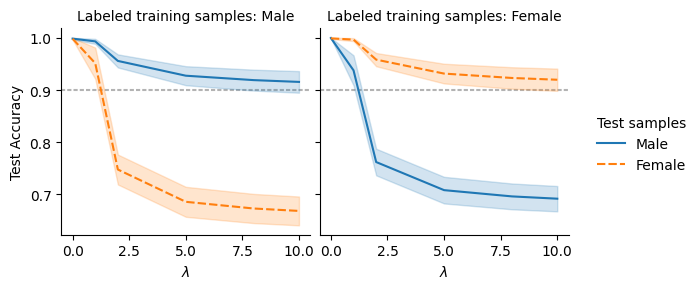

In [ ]:
# sns.set(style="white", font_scale=1.1)
g = sns.relplot(
    data=res_df_is, x="Lambda", y="Accuracy", col="Labeled training samples",
    hue="Test samples", style="Test samples", kind="line", errorbar=("sd", 1), height=3)
(g.map(plt.axhline, y=0.9, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels(r'$\lambda$', "Test Accuracy")
  .set_titles("Labeled training samples: {col_name}")
  .tight_layout(w_pad=0))
plt.savefig('figures/HCP_in_session_test.pdf', format='pdf', bbox_inches='tight')
plt.savefig('figures/HCP_in_session_test.png', format='png', bbox_inches='tight')
plt.show()

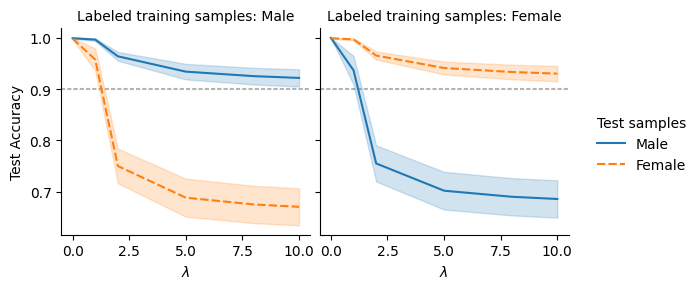

In [ ]:
g = sns.relplot(
    data=res_df_os, x="Lambda", y="Accuracy", col="Labeled training samples",
    hue="Test samples", style="Test samples", kind="line", errorbar=("sd", 1),height=3)
(g.map(plt.axhline, y=0.9, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels(r'$\lambda$', "Test Accuracy") # fontsize=12)
  .set_titles("Labeled training samples: {col_name}")
  .tight_layout(w_pad=0))
plt.savefig('figures/HCP_out_session_test.pdf', format='pdf', bbox_inches='tight')
plt.savefig('figures/HCP_out_session_test.png', format='png', bbox_inches='tight')
plt.show()

In [ ]:
gaps = {"is": {0: {"mean": [], "std": []}, 
               1: {"mean": [], "std": []}}, 
        "os": {0: {"mean": [], "std": []}, 
               1: {"mean": [], "std": []}}}

for lambda_ in lambdas:
    sub_df = res_df_all.loc[res_df_all["lambda"] == lambda_]
    for g in [0, 1]:
        sub_df_g = sub_df[sub_df["train_gender"] == g]
        for key in gaps:
            gaps[key][g]["mean"].append(np.mean(sub_df_g["gap_%s" % key].values))
            gaps[key][g]["std"].append(np.std(sub_df_g["gap_%s" % key].values))

In [ ]:
gsis = {"is": {0: {"mean": [], "std": []}, 
               1: {"mean": [], "std": []}}, 
        "os": {0: {"mean": [], "std": []}, 
               1: {"mean": [], "std": []}}}

for lambda_ in lambdas:
    sub_df = res_df_all.loc[res_df_all["lambda"] == lambda_]
    for g in [0, 1]:
        sub_df_g = sub_df[sub_df["train_gender"] == g]
        for key in gsis:
            gsis[key][g]["mean"].append(np.mean(sub_df_g["GSI_%s" % key].values))
            gsis[key][g]["std"].append(np.std(sub_df_g["GSI_%s" % key].values))

In [ ]:
def plot_gaps(gaps, dataset, fontsize=14, color="steelblue", metric="gap"):
    lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]
    plt.figure(figsize=(4, 4))
    plt.plot(lambdas, gaps['mean'], '-', c=color)
    plt.fill_between(lambdas, np.asarray(gaps['mean']) - np.asarray(gaps['std']), 
                    np.asarray(gaps['mean']) + np.asarray(gaps['std']), color=color, alpha=0.2)
    # plt.margins(x=0)
    # plt.legend(loc=5)
    # plt.ylim(bottom=0.6)
    plt.rcParams['text.usetex'] = True
    plt.xlabel(r'$\lambda$', fontsize=fontsize)
    plt.rcParams['text.usetex'] = False
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel("Accuracy gap", fontsize=fontsize)
    plt.savefig('figures/%s_acc_%s.pdf' % (dataset, metric), format='pdf', bbox_inches='tight')
    plt.savefig('figures/%s_acc_%s.png' % (dataset, metric), format='png', bbox_inches='tight')
    plt.show()

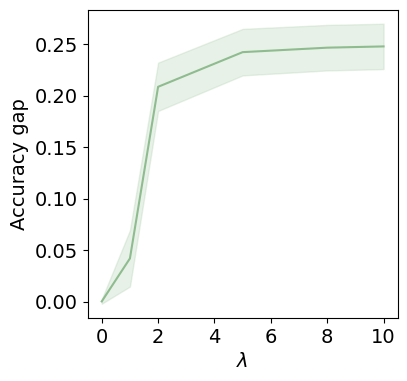

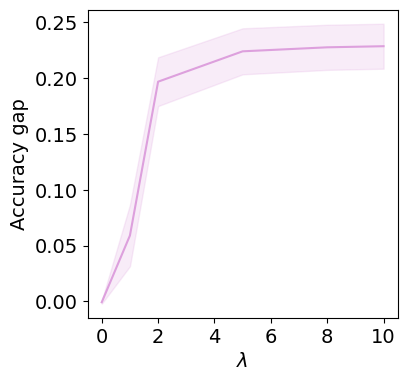

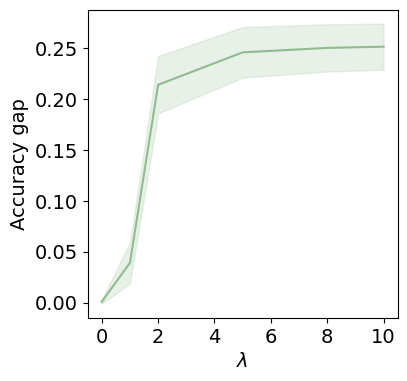

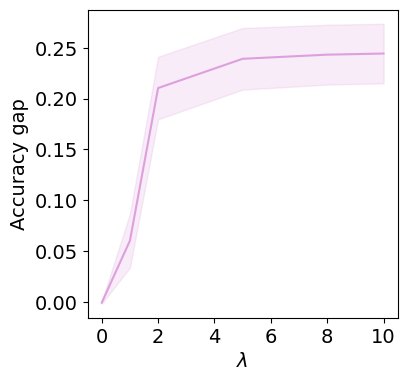

In [ ]:
for train_session in ["is", "os"]:
    plot_gaps(gaps[train_session][0], "HCP_%s0" % train_session, color="darkseagreen")
    plot_gaps(gaps[train_session][1], "HCP_%s1" % train_session, color="plum")

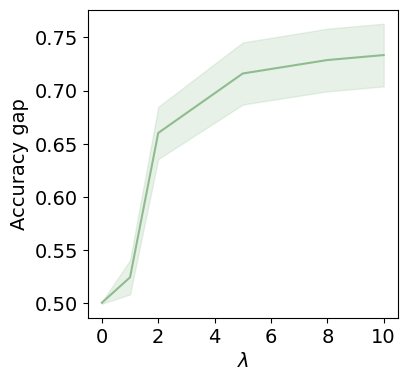

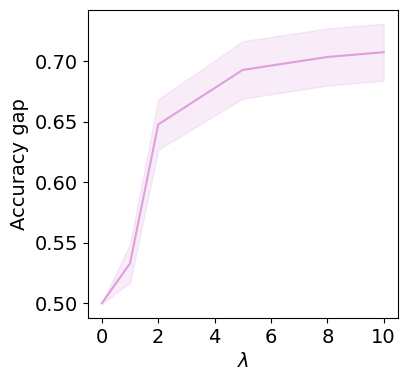

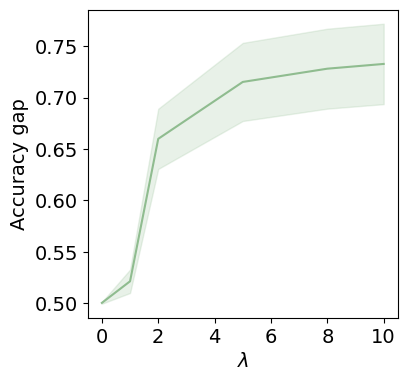

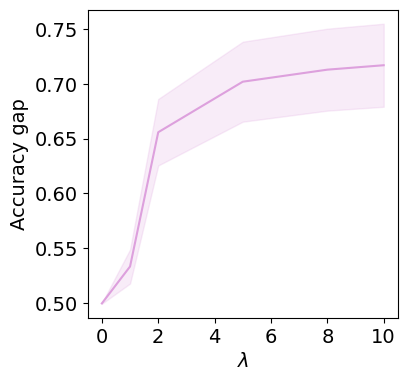

In [ ]:
for train_session in ["is", "os"]:
    plot_gaps(gsis[train_session][0], "HCP_%s0" % train_session, color="darkseagreen", metric="gsi")
    plot_gaps(gsis[train_session][1], "HCP_%s1" % train_session, color="plum", metric="gsi")

In [ ]:
lambdas = ["0_mix_gender"]
res_df_all = load_result(dataset=dataset, root_dir=model_root_dir, lambdas=lambdas, seed_start=seed_start)

res_df_all["gap_is"] = res_df_all["acc_ic_is"] - res_df_all["acc_oc_is"]
res_df_all["gap_os"] = res_df_all["acc_ic_os"] - res_df_all["acc_oc_os"]
res_df_all["GSI_is"] = res_df_all["acc_ic_is"] / (res_df_all["acc_ic_is"] + np.abs(2 * res_df_all["acc_oc_is"] - 1))
res_df_all["GSI_os"] = res_df_all["acc_ic_os"] / (res_df_all["acc_ic_os"] + np.abs(2 * res_df_all["acc_oc_os"] - 1))

res_df_is = reformat_results(res_df_all, ["acc_ic_is", "acc_oc_is"])
res_df_os = reformat_results(res_df_all, ["acc_ic_os", "acc_oc_os"])

In [ ]:
print(np.mean(res_df_is["Accuracy"]))
print(np.std(res_df_is["Accuracy"]))

0.9995905639794916
0.0010194239783747954


In [ ]:
print(np.mean(res_df_os["Accuracy"]))
print(np.std(res_df_os["Accuracy"]))

0.9995268926584487
0.0008447307486945751


### GSP

In [ ]:
model_root_dir = "/media/shuo/MyDrive/data/brain/brain_networks/gsp/Models"
seed_start = 2023
# col_names = ["acc_ic", "acc_oc", "pred_loss", "code_loss"]
dataset = "gsp"

In [ ]:
lambdas = ["0_mix_gender"]
res_df_all = load_result(dataset=dataset, root_dir=model_root_dir, 
                         lambdas=lambdas, seed_start=seed_start)
res_df_all["gap"] = res_df_all["acc_ic"] - res_df_all["acc_oc"]
res_df_all["GSI"] = res_df_all["acc_ic"] / (res_df_all["acc_ic"] + np.abs(2 * res_df_all["acc_oc"] - 1))
res_df_reformat = reformat_results(res_df_all, ["acc_ic", "acc_oc"])

In [ ]:
print(np.mean(res_df_reformat["Accuracy"]))
print(np.std(res_df_reformat["Accuracy"]))

0.9997027458148133
0.0005970221778844863


In [ ]:
lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]
res_df_all = load_result(dataset=dataset, root_dir=model_root_dir, 
                         lambdas=lambdas, seed_start=seed_start)
res_df_all["gap"] = res_df_all["acc_ic"] - res_df_all["acc_oc"]
res_df_all["GSI"] = res_df_all["acc_ic"] / (res_df_all["acc_ic"] + np.abs(2 * res_df_all["acc_oc"] - 1))
res_df_reformat = reformat_results(res_df_all, ["acc_ic", "acc_oc"])

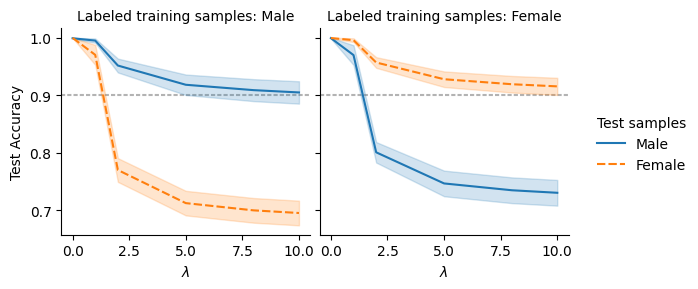

In [ ]:
g = sns.relplot(
    data=res_df_reformat, x="Lambda", y="Accuracy", col="Labeled training samples",
    hue="Test samples", style="Test samples", kind="line", errorbar=("sd", 1),height=3)
(g.map(plt.axhline, y=0.9, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels(r'$\lambda$', "Test Accuracy") # , fontsize=12)
  .set_titles("Labeled training samples: {col_name}")
  .tight_layout(w_pad=0))
plt.savefig('figures/GSP_test.pdf', format='pdf', bbox_inches='tight')
plt.savefig('figures/GSP_test.png', format='png', bbox_inches='tight')
plt.show()

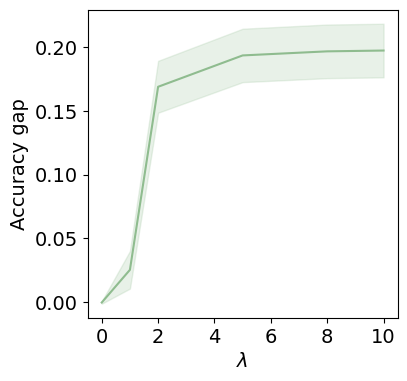

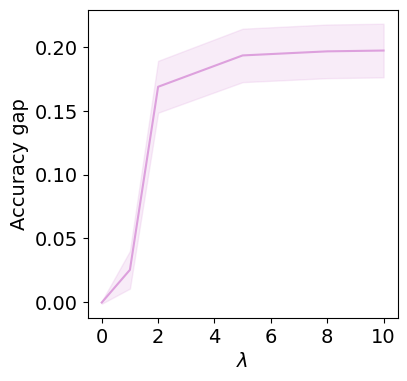

In [ ]:
# gaps = {"is": , 
#         "os": {0: {"mean": [], "std": []}, 
#                1: {"mean": [], "std": []}}}

# for lambda_ in lambdas:
#     sub_df = res_df_all.loc[res_df_all["lambda"] == lambda_]
#     for g in [0, 1]:
#         sub_df_g = sub_df[sub_df["train_gender"] == g]
#         for key in gaps:
#             gaps[key][g]["mean"].append(np.mean(sub_df_g["gap_%s" % key].values))
#             gaps[key][g]["std"].append(np.std(sub_df_g["gap_%s" % key].values))


gaps = {0: {"mean": [], "std": []}, 1: {"mean": [], "std": []}}
for lambda_ in lambdas:
    sub_df = res_df_all.loc[res_df_all["lambda"] == lambda_]
    for g in [0, 1]:
        sub_df_g = sub_df[sub_df["train_gender"] == g]
        gaps[g]["mean"].append(np.mean(sub_df["gap"].values))
        gaps[g]["std"].append(np.std(sub_df["gap"].values))
    
plot_gaps(gaps[0], "GSP_0", color="darkseagreen")
plot_gaps(gaps[1], "GSP_1", color="plum")

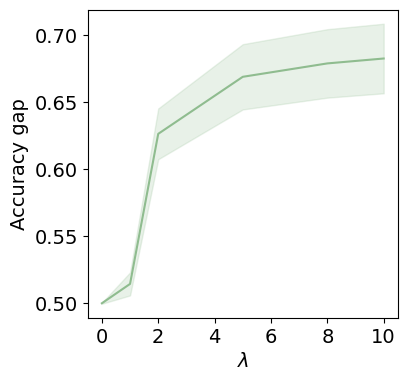

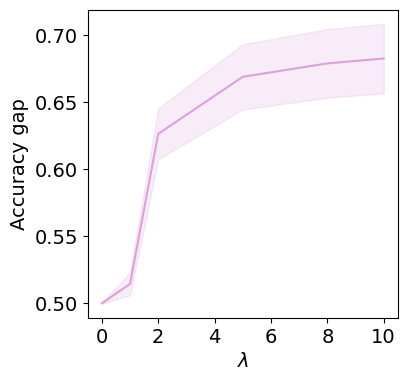

In [ ]:
# gsis = {"is": {0: {"mean": [], "std": []}, 
#                1: {"mean": [], "std": []}}, 
#         "os": {0: {"mean": [], "std": []}, 
#                1: {"mean": [], "std": []}}}

# for lambda_ in lambdas:
#     sub_df = res_df_all.loc[res_df_all["lambda"] == lambda_]
#     for g in [0, 1]:
#         sub_df_g = sub_df[sub_df["train_gender"] == g]
#         for key in gsis:
#             gsis[key][g]["mean"].append(np.mean(sub_df_g["GSI_%s" % key].values))
#             gsis[key][g]["std"].append(np.std(sub_df_g["GSI_%s" % key].values))
gsis = {0: {"mean": [], "std": []}, 1: {"mean": [], "std": []}}
for lambda_ in lambdas:
    sub_df = res_df_all.loc[res_df_all["lambda"] == lambda_]
    for g in [0, 1]:
        sub_df_g = sub_df[sub_df["train_gender"] == g]
        gsis[g]["mean"].append(np.mean(sub_df["GSI"].values))
        gsis[g]["std"].append(np.std(sub_df["GSI"].values))
    
plot_gaps(gsis[0], "GSP_0", color="darkseagreen", metric="gsi")
plot_gaps(gsis[1], "GSP_1", color="plum", metric="gsi")

### UKB

In [ ]:
model_root_dir = "/media/shuo/MyDrive/data/brain/brain_networks/ukbio/Models"
lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]
seed_start = 2023
# col_names = ["acc_ic", "acc_oc", "pred_loss", "code_loss"]
dataset = "ukb"

res_df_all = load_result(dataset=dataset, root_dir=model_root_dir, 
                         lambdas=lambdas, seed_start=seed_start)
res_df_all["gap"] = res_df_all["acc_ic"] - res_df_all["acc_oc"]
res_df_reformat = reformat_results(res_df_all, ["acc_ic", "acc_oc"], male=1)

In [ ]:
g = sns.relplot(
    data=res_df_reformat, x="Lambda", y="Accuracy", col="Labeled training samples",
    hue="Test samples", style="Test samples", kind="line", errorbar=("sd", 1),)
(g.map(plt.axhline, y=0.85, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels(r'$\lambda$', "Test Accuracy", fontsize=12)
  .set_titles("Labeled training samples: {col_name}")
  .tight_layout(w_pad=0))
plt.savefig('figures/UKB_test.pdf', format='pdf', bbox_inches='tight')
plt.savefig('figures/UKB_test.png', format='png', bbox_inches='tight')
plt.show()

## Plot weight correlation

In [ ]:
def load_weight_plot_corr(dataset, base_dir, sessions, seed_start, fontsize=14):
    control_weights = fetch_weights(base_dir, "mix", "0_mix_gender", dataset, sessions=sessions, seed_=seed_start)
    n_control_weights = control_weights.shape[0]

    lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]
    corrs = {"mean": [], "sd": []}

    for lambda_ in lambdas:
        for gender in [0, 1]:
            weights = fetch_weights(base_dir, gender, int(lambda_), dataset, sessions=sessions, seed_=seed_start)
            # n_weights = weights.shape[0]
            corr_matrix = np.corrcoef(control_weights, weights)[n_control_weights:, :n_control_weights]
            corrs["mean"].append(np.mean(corr_matrix))
            corrs["sd"].append(np.std(corr_matrix))
    
    plt.figure(figsize=(4, 4))
    plt.plot(lambdas, corrs['mean'][::2] , '-', c="steelblue")
    plt.fill_between(lambdas, np.asarray(corrs['mean'][::2]) - np.asarray(corrs['sd'][::2]), 
                    np.asarray(corrs['mean'][::2]) + np.asarray(corrs['sd'][::2]), color="steelblue", alpha=0.2)
    # plt.margins(x=0)
    # plt.legend(loc=5)
    # plt.ylim(bottom=0.6)
    plt.rcParams['text.usetex'] = True
    plt.xlabel(r'$\lambda$', fontsize=fontsize)
    plt.rcParams['text.usetex'] = False
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel("Correlation", fontsize=fontsize)
    plt.savefig('figures/%s_corr_m.pdf' % dataset, format='pdf', bbox_inches='tight')
    plt.savefig('figures/%s_corr_m.png' % dataset, format='png', bbox_inches='tight')
    plt.show()

    # plt.figure().set_figheight(4)
    plt.figure(figsize=(4, 4))
    plt.plot(lambdas, corrs['mean'][1::2] , '--', color='firebrick')
    plt.fill_between(lambdas, np.asarray(corrs['mean'][1::2]) - np.asarray(corrs['sd'][1::2]), 
                    np.asarray(corrs['mean'][1::2]) + np.asarray(corrs['sd'][1::2]), color='firebrick', alpha=0.2)
    plt.rcParams['text.usetex'] = True
    plt.xlabel(r'$\lambda$', fontsize=fontsize)
    plt.rcParams['text.usetex'] = False
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel("Correlation", fontsize=fontsize)
    plt.savefig('figures/%s_corr_f.pdf' % dataset, format='pdf', bbox_inches='tight')
    plt.savefig('figures/%s_corr_f.png' % dataset, format='png', bbox_inches='tight')
    plt.show()  

### GSP

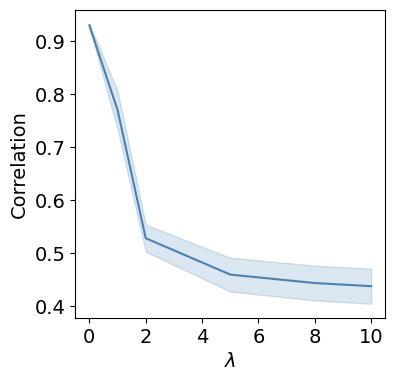

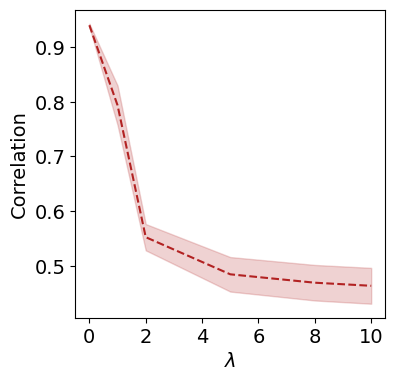

In [ ]:
dataset = "gsp"
base_dir = "/media/shuo/MyDrive/data/brain/brain_networks/gsp/Models"
sessions = [""]
seed_ = 2023

load_weight_plot_corr(dataset, base_dir, sessions, seed_)

### HCP

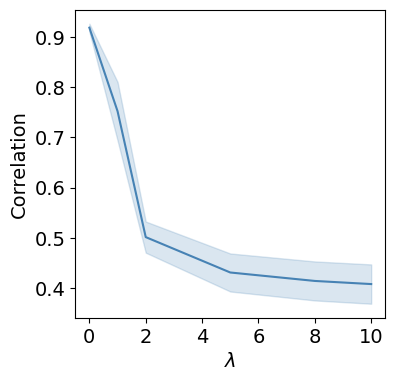

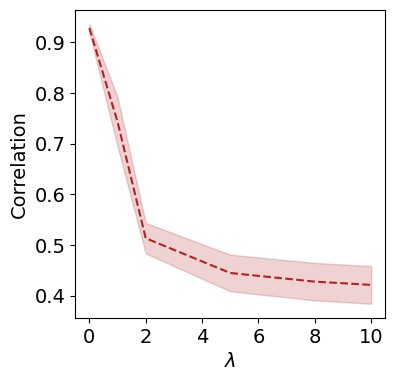

In [ ]:
dataset = "HCP"
base_dir = "/media/shuo/MyDrive/data/HCP/BNA/Models"
sessions = ["REST1_", "REST2_"]
seed_ = 2022

load_weight_plot_corr(dataset, base_dir, sessions, seed_)

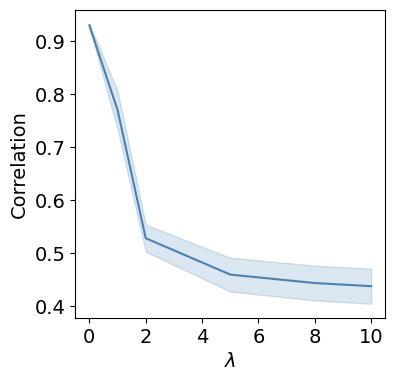

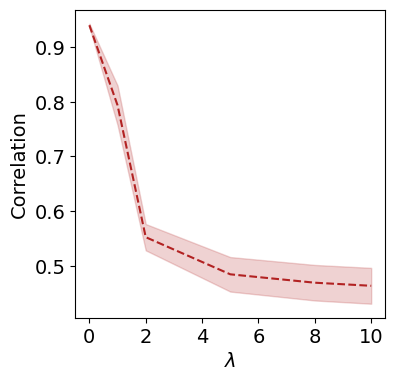

In [ ]:
# plt.figure().set_figheight(4)
fontsize = 14

plt.figure(figsize=(4, 4))
plt.plot(lambdas, corrs['mean'][::2] , '-', c="steelblue")
plt.fill_between(lambdas, np.asarray(corrs['mean'][::2]) - np.asarray(corrs['sd'][::2]), 
                 np.asarray(corrs['mean'][::2]) + np.asarray(corrs['sd'][::2]), color="steelblue", alpha=0.2)
# plt.margins(x=0)
# plt.legend(loc=5)
# plt.ylim(bottom=0.6)
plt.rcParams['text.usetex'] = True
plt.xlabel(r'$\lambda$', fontsize=fontsize)
plt.rcParams['text.usetex'] = False
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Correlation", fontsize=fontsize)
plt.savefig('figures/%s_corr_m.pdf' % dataset, format='pdf', bbox_inches='tight')
plt.savefig('figures/%s_corr_m.png' % dataset, format='png', bbox_inches='tight')
plt.show()

# plt.figure().set_figheight(4)
plt.figure(figsize=(4, 4))
plt.plot(lambdas, corrs['mean'][1::2] , '--', color='firebrick')
plt.fill_between(lambdas, np.asarray(corrs['mean'][1::2]) - np.asarray(corrs['sd'][1::2]), 
                 np.asarray(corrs['mean'][1::2]) + np.asarray(corrs['sd'][1::2]), color='firebrick', alpha=0.2)
plt.rcParams['text.usetex'] = True
plt.xlabel(r'$\lambda$', fontsize=fontsize)
plt.rcParams['text.usetex'] = False
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Correlation", fontsize=fontsize)
plt.savefig('figures/%s_corr_f.pdf' % dataset, format='pdf', bbox_inches='tight')
plt.savefig('figures/%s_corr_f.png' % dataset, format='png', bbox_inches='tight')
plt.show()

### Correlation matrix

In [ ]:
weights_dirs = {
    "Multivariate Control HCP": "./first-order/HCP/HCP_L0Gmix.mat", 
    "Multivariate Control GSP": "./first-order/GSP/GSP_L0_mix_genderGmix.mat",
    "GSDA $\lambda=0$ Male HCP": "./first-order/HCP/HCP_L0G0.mat", 
    "GSDA $\lambda=0$ Female HCP": "./first-order/HCP/HCP_L0G1.mat", 
    "GSDA $\lambda=0$ Male GSP": "./first-order/GSP/GSP_L0G0.mat", 
    "GSDA $\lambda=0$ Female GSP": "./first-order/GSP/GSP_L0G1.mat", 
    "GSDA $\lambda=5$ Male HCP": "./first-order/HCP/HCP_L5G0.mat", 
    "GSDA $\lambda=5$ Female HCP": "./first-order/HCP/HCP_L5G1.mat", 
    "GSDA $\lambda=5$ Male GSP": "./first-order/GSP/GSP_L5G0.mat", 
    "GSDA $\lambda=5$ Female GSP": "./first-order/GSP/GSP_L5G1.mat", 
    }

weights = dict()

for key in weights_dirs:
    # print(key)
    weights[key] = loadmat(weights_dirs[key])["mean"][0][1:]
    
weight_df = pd.DataFrame(weights)

HCP_tval = pd.read_csv("../PostAnalysis/Chord/Univariate/REST1_univariate_L_vs_R_gender_tvalue_uncorrected.csv")
HCP_tval = HCP_tval.rename(columns={'M_F': 'Univariate control HCP ', 'M': 'Univariate Male HCP', 'F': 'Univariate Female HCP'})
GSP_tval = pd.read_csv("../PostAnalysis/Chord/Univariate/GSP_univariate_L_vs_R_gender_tvalue_uncorrected.csv")
GSP_tval = GSP_tval.rename(columns={'M_F': 'Univariate control GSP ', 'M': 'Univariate Male GSP', 'F': 'Univariate Female GSP'})

weight_df = pd.concat((HCP_tval, GSP_tval, weight_df), axis=1)

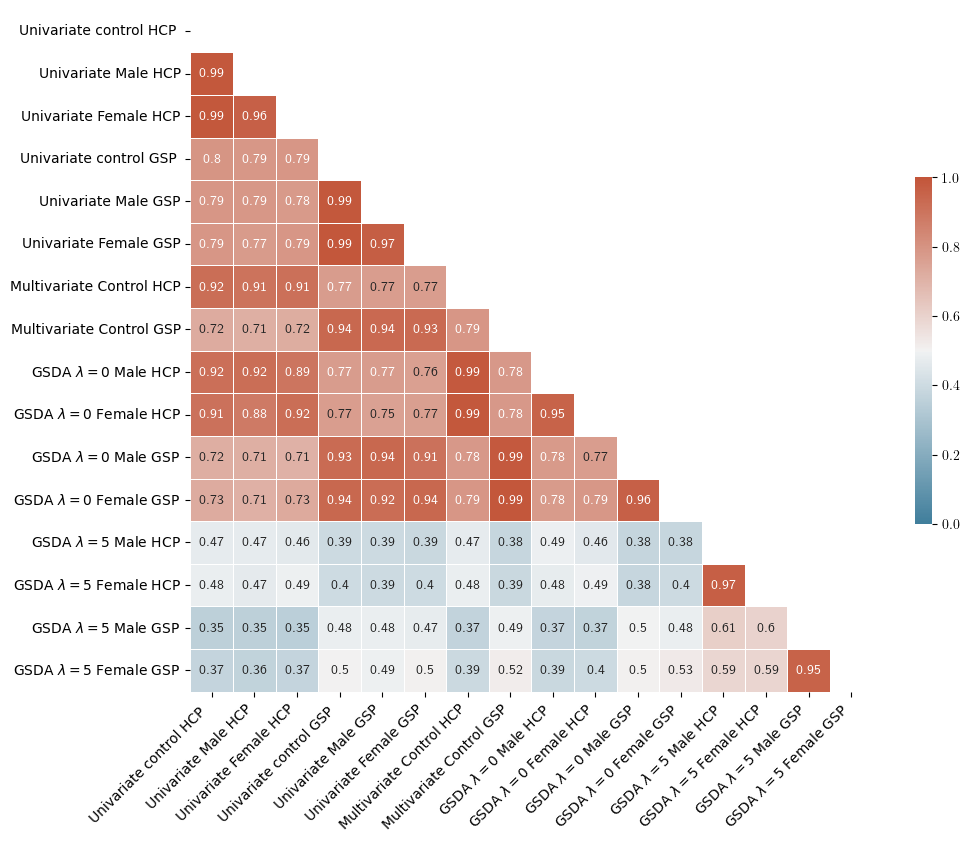

In [ ]:
corr = weight_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.rcParams['text.usetex'] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, vmax=1, center=0.5, annot=True, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
            # cbar_kws={"shrink": .5, "use_gridspec": False, "location": "top"})  #, annot_kws={"rotation": 45})
plt.rcParams['text.usetex'] = False
# plt.tick_params(axis='x', labelrotation=45)
ax.set_xticklabels(list(weight_df.columns.values), rotation = 45, ha="right")
# plt.savefig('corr.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('corr.png', format='png', bbox_inches='tight')
plt.savefig('figures/corr_annot.pdf', format='pdf', bbox_inches='tight')
plt.savefig('figures/corr_annot.png', format='png', bbox_inches='tight')
plt.show()

In [ ]:
def load_coef_plot_corr(dataset, sex_label):
    weights_dirs = dict()
    lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]
    sex_dict = {0: "Male", 1: "Female"}
    for lambda_ in lambdas:
        weights_dirs["GSDA $\lambda=%s$" % (int(lambda_))] = "./first-order/%s/%s_L%sG%s.mat" % (dataset, dataset, int(lambda_), sex_label)

    weights = dict()

    for key in weights_dirs:
        # print(key)
        weights[key] = loadmat(weights_dirs[key])["mean"][0][1:]
        
    weight_df = pd.DataFrame(weights)
    
    corr = weight_df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.rcParams['text.usetex'] = True
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, vmax=1, center=0.5, annot=True, 
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
                # cbar_kws={"shrink": .5, "use_gridspec": False, "location": "top"})  #, annot_kws={"rotation": 45})
    plt.rcParams['text.usetex'] = False
    # plt.tick_params(axis='x', labelrotation=45)
    ax.set_xticklabels(list(weight_df.columns.values), rotation = 45, ha="right")
    # plt.savefig('corr.pdf', format='pdf', bbox_inches='tight')
    # plt.savefig('corr.png', format='png', bbox_inches='tight')
    plt.savefig('figures/corr_annot_%s_%s.pdf' % (dataset, sex_dict[sex_label]), format='pdf', bbox_inches='tight')
    plt.savefig('figures/corr_annot_%s_%s.png' % (dataset, sex_dict[sex_label]), format='png', bbox_inches='tight')
    plt.show()

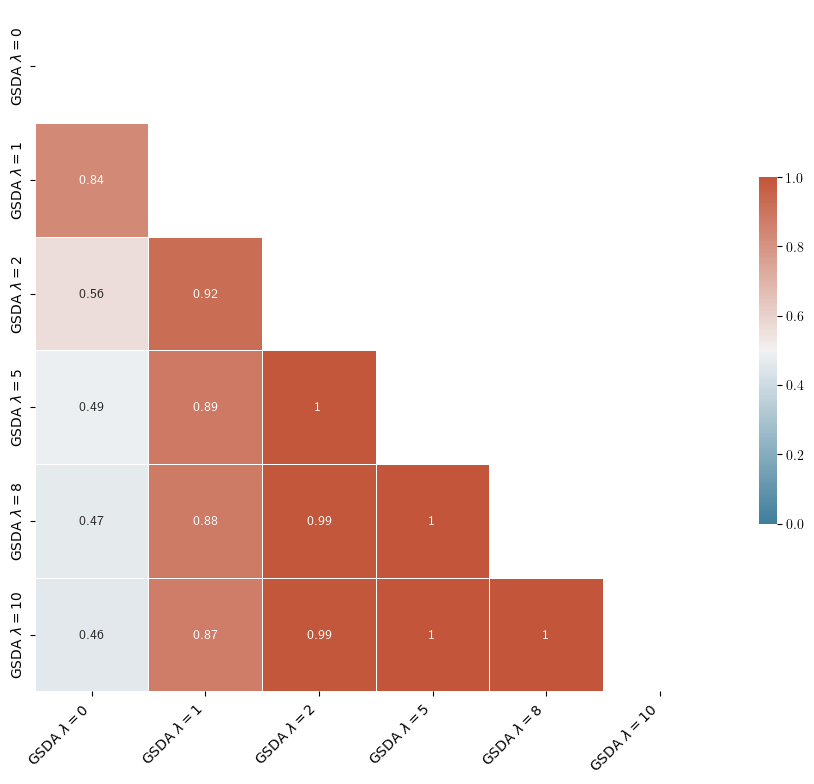

In [ ]:
load_coef_plot_corr("HCP", 0)

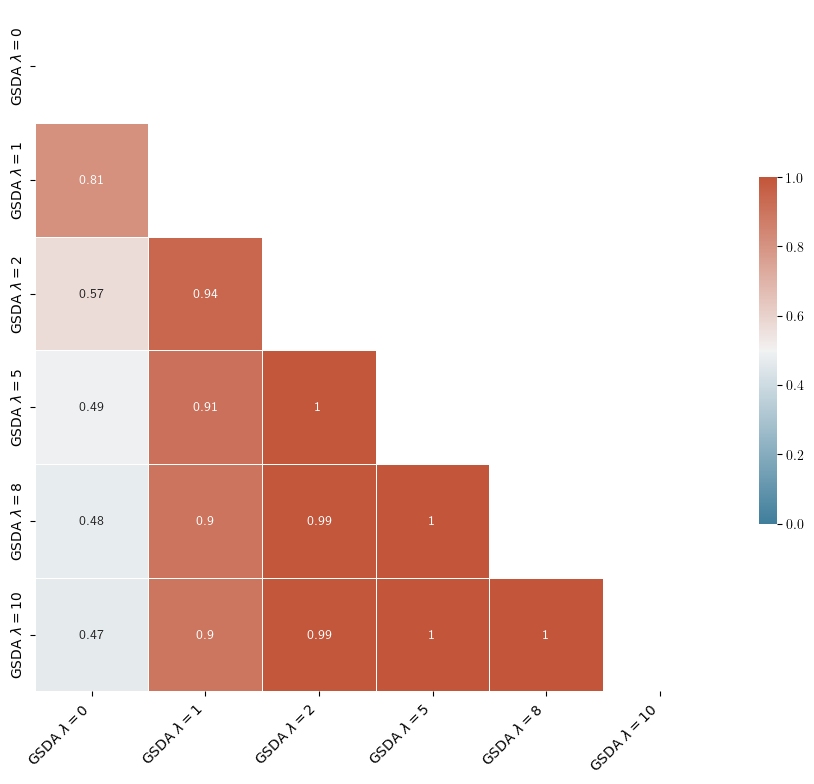

In [ ]:
load_coef_plot_corr("HCP", 1)

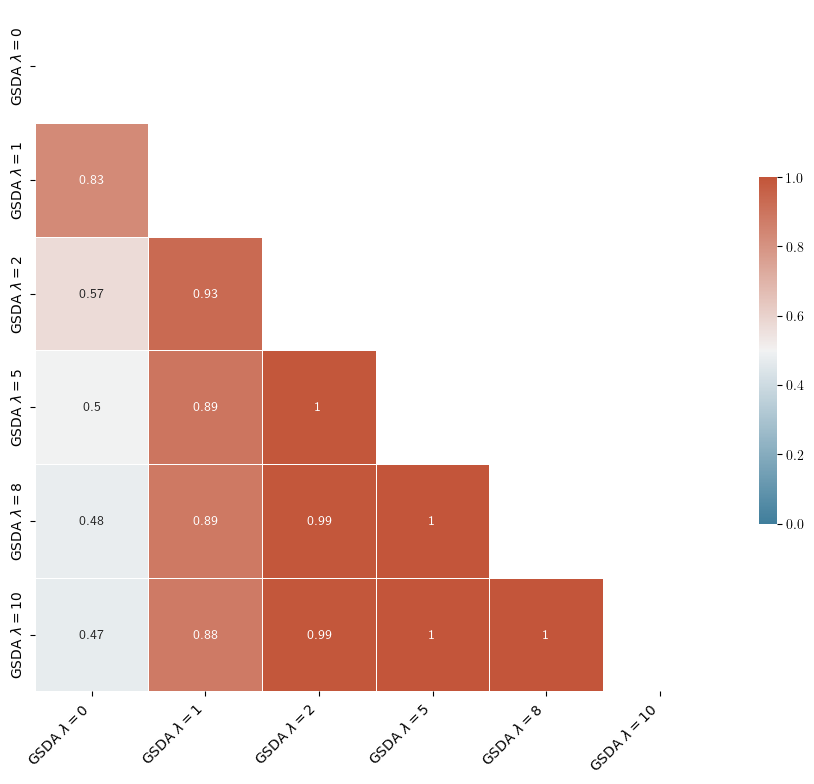

In [ ]:
load_coef_plot_corr("GSP", 0)

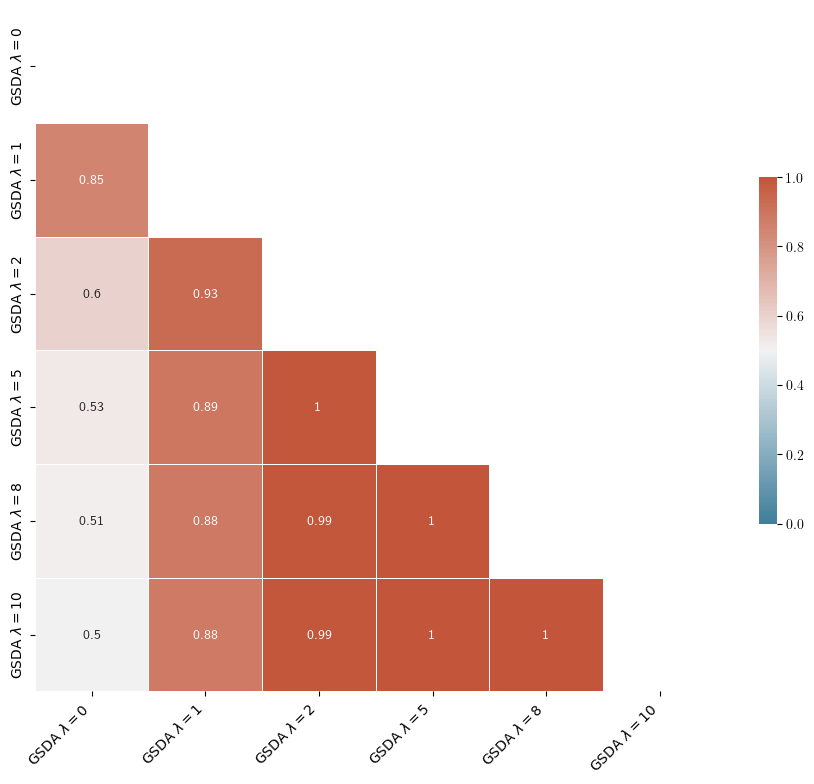

In [ ]:
load_coef_plot_corr("GSP", 1)